# 8. 뉴스 요약 봇 만들기

텍스트 요약의 핵심은 정보를 압축한 후에 정보 손실 발생이 최소화되어야한다. 요약 문장을 만들어 내는 방법은 크게 추출적 요약(Extractive Summarization), 추상적 요약(Abstactive Summarization) 두 가지 접근으로 나눌 수 있다.

- 추출적 요약(Extractive Summarization)   
원문의 문장들을 추출해서 요약하는 방식이다. 예를들어 10개의 문장으로 구성된 문단에서 핵심 문장 3개를 꺼내 요악문을 만드는 방식이다. 하지만 이들이 자연스럽지 않을 수 있다. 딥러닝보다 머신러닝 방식에 속하는 텍스트 랭크같은 알고리즘을 사용해서 이 방법을 사용한다. 예를들어 네이버 뉴스의 요약봇이 이에 해당한다.

- 추상적 요약(Abstacktive Summarization)   
원문에서 새로운 문장을 생성해내는 방식이다. 자연어 생성(Natural Language Generation, NLG)의 영역이다. 문단에서 핵심문장을 판단하는 점에서 문장 분류 문제로 볼 수 있다.   
RNN을 이용해서 전에 문장 만들기를 해봤는데 앞에 있는 정보보다 뒤로 갈수록 중요도가 올라가는 장기 의존성 문제 때문에 이를 사용하긴 어려워 보인다.   
[구글 인공지능이 만든 해드라인 기사](https://zdnet.co.kr/view/?no=20160905114833&from=Mobile)를 보면 이런 문제를 해결했는데 추상적 요약이라 불리는 '시퀀스 투 시퀀스' 방식을 사용했다. 

# seq2seq
![](https://miro.medium.com/max/1360/1*Cu49wPEpWJPoI0a5AV9Q1Q.png)

첫번째 RNN인 인코더를 문맥 정보를 갖고있는 컨텍스트 벡터로 변환하고 고정한다. 두번째 RNN 디코더부터 컨텍스트 벡터를 입력받아 한 단어씩 생성해 요약 문장을 완성하는 과정이다.   
seq2seq를 구현할 때 바닐라 RNN이 아닌 LSTM을 사용해보자. 특징은 time step의 셀에 hidden state, cell state가 같이 전달한다.   
seq2seq 구조에서 디코더는 시작 토큰 SOS가 입력되면 종료 토큰 EOS를 예측하는 순간까지 멈추지 않고 진행한다.    

![](https://wikidocs.net/images/page/22893/dotproductattention1_final.PNG)

seq2seq 인코더의 마지막 time step의 hidden state를 컨텍스트 벡터로 사용했다. 하지만 RNN 계열의 한계로 많은 정보가 손실된 상태이다. 그래서 __어텐션 메커니즘을__ 사용해서 인코더의 모든 step이 hidden state의 컨텍스트 벡터에 반영되도록 하자.   
주의할점은 디코더의 스텝에 따라 인코더의 hidden state의 가중치 값이 달라진다. 기본적인 seq2seq 모델의 컨텍스트 벡터는 위치와 무관하게 한번 계산되면 고정값을 가진다.

# 데이터 준비하기

Kaggle에 제공된 아마존 리뷰 데이터셋을 사용할 예정이다. 또한 NLTK의 stopwords를 사용할 것이다.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
# Reviews.csv의 총 568,454개중 10만개만 사용
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
32179,Pops well with air popper. Decent flavor (thou...,Solid choice for popcorn
10883,So the hottest-hot-off-the-press recommendatio...,wow really
44265,When I was opening the boxes I noticed there w...,Not All French Roast KCups
36653,I am currently on a No Carb diet and bought th...,GREAT AFTER A FEW RINSES!
82951,San Francisco Bay Coffee OneCup for Keurig K-C...,San Francisco Bay Coffee for Keurig Brewer
60228,I enjoy these wintergreen flavored lifesavers....,Minty fresh breath
48940,I've been using this product for the last thre...,Amazing Seeds
45180,"<a href=""http://www.amazon.com/gp/product/B000...",a hope full wish
1676,"Great low cal snack... satisfies the crunchy, ...",Love these!
19362,Bought a small SmartBones chicken dog chew for...,Made in China!!!


# 데이터 전처리하기

## 데이터 정리

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외하면 Text는 88426개 Summary는 72348개가 나온다.   
`drop_duplicates()`를 사용해서 중복 샘플 제거하기, `dropna()`를 사용해서 Null 제거하기

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# null값 확인하기
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


## 텍스트 정규화(text normalization)   
- 같은 의미인데 다른 단어 정규화   
사전은 [정규화 사전 출저](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python) 참고
- 자주 등장하지만 도움이 되지 않는 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [11]:
# 임의의 예시를 만들어서 확인해보기
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [12]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


Summary에 전처리를 할때는 불용어 제거를 하지 않는다는 뜻에서 두번째 인자로 False 넣어주기

In [13]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [14]:
# 전처리하고 empty 샘플들 확인 후 Null 값 넣기
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [15]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [16]:
# 생긴 Null값들 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


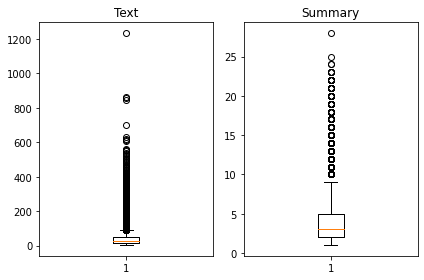

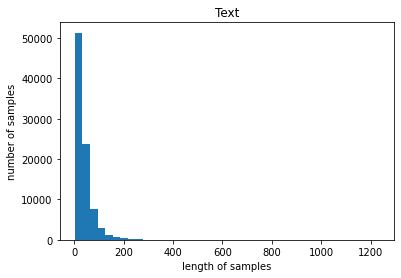

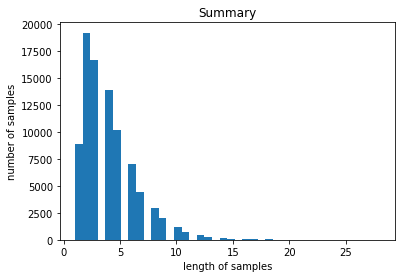

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 최소 길이는 2 최대 길이는 1235로 차이가 크다 평균 길이는 38이고 대체적으로 100내외의 길이를 가진다.   
Summary의 경우 최소는 1, 최대 28 평균이 4로 상대적으로 많이 짧고 대체적으로 10 이하의 길이를 갖고 있다.   
최대 길이를 임의로 정한 후 데이터의 몇 퍼센트에 해당하는지 확인해보고 괜찮으면 정제하자

In [18]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [21]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


## 시작 토큰, 종료 토큰 추가하기
앞서 말한것처럼 seq2seq 훈련을 위해 디코더의 시작과 종료 토큰을 추가해줘야한다. 시작 토큰 `SOS, sostoken`, 종료 토큰 `EOS, eostoken`라 명명하고 추가해주자. 

In [22]:
# Summary에 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [23]:
# Numpy 타입으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


## 훈련 데이터와 테스트 데이터 분리

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  418 24742 38672 ... 18953 55607 14944]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


## 정수 인코딩

단어들을 정수로 바꿔주는 맵핑 작업이 필요하다. 이를 단어 집합(vocabulary)을 만든다고 표현한다.   
Keras의 tokenizer를 이용하면 단어 집합을 만들 수 있다.

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


등장 빈도수가 7회 미마인 데이터들의 비중을 확인하기   
`src_tokenizer.word_counts.items()`를 확인하면 등장 빈도수가 저장되어 있다.

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32061
등장 빈도가 6번 이하인 희귀 단어의 수: 23823
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8238
단어 집합에서 희귀 단어의 비율: 74.3052306540657
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4066122840085984


32086개의 단어로 6회 이하 등장한 단어들은 74%나 된다. 하지만 훈련 데이터에서 등장 빈도로 차지하는 비율은 3.39%밖에 되지 않는다. 그래서 6회 이하의 단어들은 인코딩 과정에서 빼고 훈련 데이터에서 제거하고 진행해보자.

In [30]:
src_vocab = 8000 # 단어 집합의 크기를 8,000으로 제한
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5681, 864, 1248, 111, 3, 219, 6449, 3739, 53, 513, 127, 47, 1248, 111, 163, 50, 1107, 5895, 7, 151, 507, 159, 89, 3910, 111, 14, 163, 3, 9, 185], [407, 194, 26, 38, 165, 2, 891, 356, 440, 168, 4500, 1791, 2649, 99, 165, 91, 203, 2650, 107, 12, 67, 1776], [47, 957, 936, 189, 161, 47, 807, 344, 3541, 1108, 39, 1620, 76, 1207, 47, 12, 189, 957, 47, 2]]


In [32]:
# Summary 데이터에도 적용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10541
등장 빈도가 5번 이하인 희귀 단어의 수: 8167
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2374
단어 집합에서 희귀 단어의 비율: 77.47841760743762
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.911211229750742


5회 이하인 단어들은 8077개인데 실제 훈련 데이터에서 등장 빈도의 비중은 5.87%밖에 되지 않는다. 그래서 어림잡아 2000개만 집합의 크기로 잡아 진행하자.

In [34]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 98], [1], [1, 498], [1, 80, 6, 1055, 5, 112], [1, 3, 136, 1962, 75]]
target
decoder  [[3, 98, 2], [2], [498, 2], [80, 6, 1055, 5, 112, 2], [3, 136, 1962, 75, 2]]


정수 인코딩 작업이 끝났다. 하지만 체크해야할 점이 있다. 빈도수가 낮은 단어로만 구성된 샘플들은 empty 샘플이 되었을 가능성이 있으므로 확인해보자.   
decoder_input에는 sostoken, decoder_target에는 eostoken이 추가된 상태이므로 이를 주의하자

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1283
삭제할 테스트 데이터의 개수 : 325
훈련 데이터의 개수 : 51372
훈련 레이블의 개수 : 51372
테스트 데이터의 개수 : 12838
테스트 레이블의 개수 : 12838


## 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


# 모델 설계하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 hidden state는 256으로 정했다. hidden state는 LSTM에서 capacity를 정하는 파라미터이다. 3개의 층을 지나서 인코더로부터 나온 벡터는 디코더로 보내줘야한다.   
LSTM은 dropout뿐만 아니라 recurrent dropout까지 사용한다. 일반적인 dropout은 레이어의 weight를 랜덤으로 생각하여 overfitting을 저지해주지만 이는 레이어가 아닌 time step마다 해주는 방식이다. 그래서 regularization 효과와 overfitting을 방지할 수 있다.   

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # initial_state에 hidden state, cell state값 넣어주기

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 어텐션 메커니즘
텐서플로우에 이미 구현된 Bahdanau 스타일 어텐션을 가져와서 적용해보자. [텐서플로우 bahdanau docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델 훈련

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 138s 643ms/step - loss: 2.7051 - val_loss: 2.4177
Epoch 2/50
201/201 [==============================] - 126s 629ms/step - loss: 2.3806 - val_loss: 2.2797
Epoch 3/50
201/201 [==============================] - 128s 636ms/step - loss: 2.2338 - val_loss: 2.1535
Epoch 4/50
201/201 [==============================] - 129s 642ms/step - loss: 2.1121 - val_loss: 2.0645
Epoch 5/50
201/201 [==============================] - 130s 645ms/step - loss: 2.0293 - val_loss: 2.0142
Epoch 6/50
201/201 [==============================] - 127s 633ms/step - loss: 1.9672 - val_loss: 1.9766
Epoch 7/50
201/201 [==============================] - 128s 637ms/step - loss: 1.9143 - val_loss: 1.9438
Epoch 8/50
201/201 [==============================] - 127s 634ms/step - loss: 1.8677 - val_loss: 1.9177
Epoch 9/50
201/201 [==============================] - 129s 644ms/step - loss: 1.8289 - val_loss: 1.8971
Epoch 10/50
201/201 [==============================] - 128s 636m

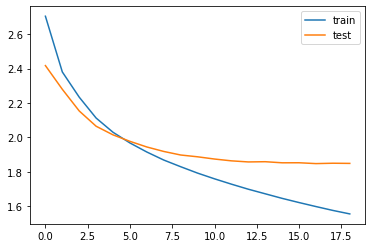

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작하는 인퍼런스 단계의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [46]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 모델 테스트

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 함수 만들기   
Text의 정수 시퀀스에서 패딩을 위해 사용한 숫자 0 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작, 종료 토큰 인덱스를 출력에서 제외하기

In [47]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [48]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : lot reviews say stuff works traveling long boring staying clear head writing book reading boring stuff keeps activity hand seems get past big lunch sleepy time follows give try keep 
실제 요약 : it works 
예측 요약 :  great for breakfast


원문 : stuff awful tasted like water soaked except better flavor mud coffee aroma flavor stomach still really dont know low acid decaf unexpected bonus also got terrible headache bunch crap 
실제 요약 : terrible stuff 
예측 요약 :  tastes like plastic


원문 : perfect brand familiar good source 
실제 요약 : getting to find 
예측 요약 :  great taste


원문 : great grain free dog food dogs love great tummies buying food months dogs happy coats shiny know getting nutritious meal 
실제 요약 : perfect for my dogs 
예측 요약 :  great dog food


원문 : sauce great almost everything love eggs chicken etc far sellers see charging way much money shipping one buying shipping handling reasonable cost way high stores around add shipping really robbery 
실제 요약 : great spicy sauce 
예측 요약 :  great pro

예측 요약 :  cookies


원문 : stopped drinking soda months ago saw product since splenda sweetner decided try love first sip pink lemonade flavor ordered two also promotion like fact fills gms protein also fiber huge plus book deal amazon really good costs whole lot live stocked summer promotion health try may like 
실제 요약 : am addicted to this healthy soda alternative 
예측 요약 :  best ever


원문 : usually find local health food store great tasty product think people would enjoy great entertaining family friends 
실제 요약 : excellent product 
예측 요약 :  great product


원문 : great tasting healthy rice cooks well rice cooker brown rice option 
실제 요약 : excellent rice 
예측 요약 :  great rice


원문 : simply best bacon ever eaten fries nice delicious think well worth price 
실제 요약 : best bacon ever 
예측 요약 :  amazing


원문 : bought christmas gift arrived well packaged gift well received hershey chocolate kisses wrapping christmas like 
실제 요약 : always good 
예측 요약 :  great gift


원문 : filler ingredients could dryer

테스트 데이터에서 50개의 샘플의 결과를 확인하자 기존 요약과는 다른 요약을 출력하면서 원문의 내용을 담고 있는 의미 있는 요약들이 보인다. 워드 임베딩과 RNN의 조합으로 이뤄냈다.   
그러나 좋지 않은 요약의 예도 있다. 성능 개선하기 위해 어텐션 조합을 수정하거나, 빔 서치(beam search), 사전 훈련된 워드 임베딩, 인코더와 디코더 자체의 구조를 변경하는 트랜스포머같은 개선 방안들이 존재한다.

# 추출적 요약 해보기

패키지 `Summa`에선 추출적 요약 모듈인 summarize를 제공해서 이를 이용해보자.   
> $ pip list | grep summa

In [49]:
import requests
from summa.summarizer import summarize

In [50]:
# 매트릭스 시놉시스 다운하기
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [51]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summarize 사용하기

summarize()의 인자로 사용되는 값들을 알아보자
> text(str): 요약할 테스트   
ratio(float, optional): 요약문에서 원본으로 선택되는 문장 비율 0~1   
words(int or None, optional): 출력에 포함할 단어 수, 만약 ratio와 함께 두 파라미터가 모두 제공되면 ratio는 무시한다.   
split(bool, optional): True면 문장 list/False는 join된 문자열 반환한다   

summarize는 문장 토큰화를 별도로 진행하지 않아도 내부적으로 문장 토큰화를 수행한다.

In [52]:
print('Summary:')
print(summarize(text, ratio=0.005)) # 원문의 0.005% 출력하기

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [53]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True)) # 리스트로 받기위해 split=True

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [54]:
print('Summary:')
print(summarize(text, words=50)) # 단어의 수로 요약문의 크기 조절하기

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 뉴스 기사 요약해보기

[News_Summary 사용하기](https://github.com/sunnysai12345/News_Summary)

In [55]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
36678,This is all imagination: Videocon chief on loo...,Denying the news of a look out circular agains...
10050,"In 10 years, Jet Airways lost 3 times of what ...",India's largest full-service carrier Jet Airwa...
46207,My sorrow is there may be no afterlife: Sridev...,"Late actress Sridevi, in an old interview with..."
34261,US couple with 13 boys welcomes 14th son,"An American woman, who already has 13 sons wit..."
38658,K'taka HC scraps panel comprising Sachin Bansa...,The Karnataka High Court has scrapped the Beng...
1000,Never experienced it in my life: Kohli on suns...,On being asked about sunstrike break in the fi...
59531,Reality too bitter to be shown: Mahira on her ...,Pakistani actress Mahira Khan tweeted a discla...
36391,Swiss Aviation Consulting denies bid for Air I...,Aviation advisory firm Swiss Aviation Consulti...
43158,SL fans celebrating India win one of the best ...,Rohit Sharma took to Twitter to share a pictur...
87187,"Egypt blocks financial newspaper, widening med...",Egypt has blocked the website of one of its mo...


text와 headlines 두 가지 열로 구성되어 있다. 추상적 요약을 하는 경우에 text를 본문, headlines를 요약된 데이터로 삼아 모델을 학습할 수 있다. 추출적 요약을 사용하면 text열만 사용하면 된다.

- Step 2. 데이터 전처리하기(추상적 요약하기)
- Step 3. 어텐션 메커니즘 사용하기(추상적 요약)
- Step 4. 실제 결과와 요약문 비교하기(추상적 요약)
- Step 5. Summa를 이용한 추출적 요약 해보기